In [1]:
# Biblotecas de manipulação de dados
import numpy as np
import pandas as pd
# Bibliotecas de visualização
import seaborn as sns
import matplotlib.pyplot as plt
# Testes estatísticos
from scipy.stats import ttest_ind
# Bibliotecas Locais
from carga import *
from tratamentos import *
from categorizacao import *

pfEnade = doCarga('microdados_enade_2019.txt')
# TRATAMENTOS 
pfEnade = doIdade(pfEnade)
pfEnade = doNota(pfEnade)
pfEnade = doVazios(pfEnade)
pfEnade = doPublicoPrivada(pfEnade)
pfEnade = doHumanasExatas(pfEnade)
pfEnade = doRenda(pfEnade)
pfEnade = doMigracao(pfEnade)
# TRATAMENTOS - Dicionários
pfEnade = doRenda(pfEnade)
#pfEnade['Renda'].value_counts().sort_index()
# pfEnade.isna().sum()    # Mostra se há vazios
pfEnade = doEscolaridade(pfEnade)

In [2]:
# TABELA - ÚTIL - Incluído
# Renda Familiar X Nota
tmp = pfEnade.groupby('QE_I08')['NT_GER'].agg(['mean', 'std', 'count']).sort_index()
tmp.index = pd.Series(tmp.index).replace(doRendaDIC())
tmp.index.name = 'Qual a renda total de sua família, incluindo seus rendimentos?'
tmp 

,mean,std,count
"Qual a renda total de sua família, incluindo seus rendimentos?",,,
"Até 1,5 salário mínimo (até R$ 1.431,00)",41.365169,13.988221,60940
"De 1,5 a 3 salários mínimos (R$ 1.431,01 a R$ 2.862,00)",42.788669,13.885542,93186
"De 3 a 4,5 salários mínimos (R$ 2.862,01 a R$ 4.293,00)",44.500582,14.124104,66823
"De 4,5 a 6 salários mínimos (R$ 4.293,01 a R$ 5.724,00)",46.036157,14.314582,37581
"De 6 a 10 salários mínimos (R$ 5.724,01 a R$ 9.540,00)",48.083174,14.407230,40163
"De 10 a 30 salários mínimos (R$ 9.540,01 a R$ 28.620,00)",51.244375,14.210903,27342
"Acima de 30 salários mínimos (mais de R$ 28.620,00)",53.146937,13.908866,5714


<AxesSubplot:>

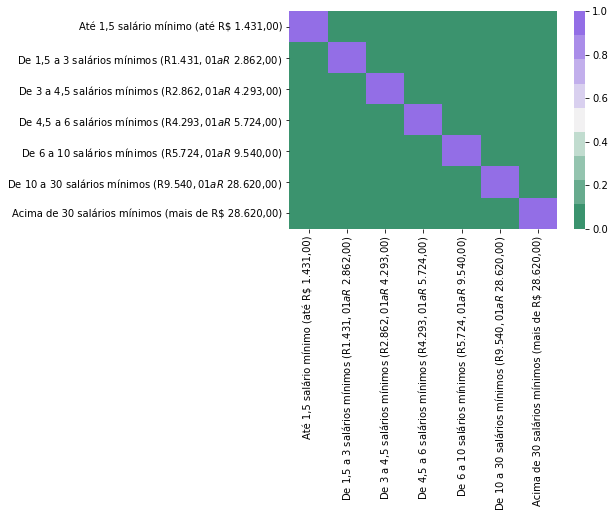

In [3]:
# MAPA CALOR - ÚTIL - Incluído
# CORRELAÇÂO - Renda Familiar e Nota
lista_de_listas = []
valores = sorted(pfEnade['QE_I08'].dropna().unique().tolist())
for i in valores:
    lista_de_listas.append([])
    for j in valores:
        t_res = ttest_ind(pfEnade.query(f'QE_I08 == @i')['NT_GER'], pfEnade.query(f'QE_I08 == @j')['NT_GER'])
        lista_de_listas[-1].append(t_res.pvalue)

valores = pd.Series(valores).replace(doRendaDIC())
tmp = pd.DataFrame(lista_de_listas, index=valores, columns=valores)    

sns.heatmap(tmp, cmap=sns.diverging_palette(150, 275, s=80, l=55, n=9))

In [4]:
# TABELA - ÚTIL - Incluído
# Horas de Estudo X Renda Familiar
tmp = pfEnade.groupby('QE_I23')['NT_GER'].agg(['mean', 'std', 'count']).sort_index()
tmp.index = pd.Series(tmp.index).replace(doHEstudoDIC())
tmp.index.name = 'Horas de estudo extra classe?'
tmp 

,mean,std,count
Horas de estudo extra classe?,,,
"Nenhuma, apenas assisto às aulas",40.557284,14.215812,11464
De uma a três,41.679172,13.734239,129434
De quatro a sete,45.185336,14.112325,100623
De oito a doze,47.881736,14.341047,45887
Mais de doze,50.615264,14.548611,44341


<AxesSubplot:>

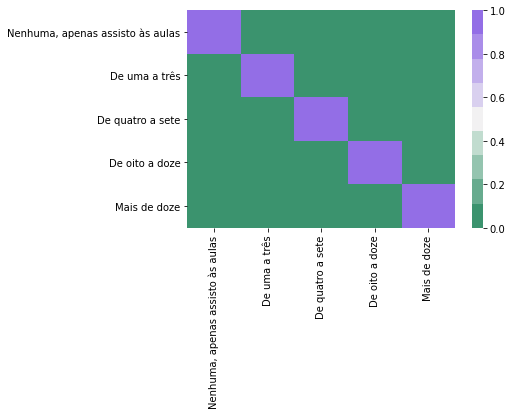

In [5]:
# MAPA CALOR - ÚTIL - NÂO incluído
# CORRELAÇÂO entre os grupos de horas de estudos
lista_de_listas = []
valores = sorted(pfEnade['QE_I23'].dropna().unique().tolist())
for i in valores:
    lista_de_listas.append([])
    for j in valores:
        t_res = ttest_ind(pfEnade.query(f'QE_I23 == @i')['NT_GER'], pfEnade.query(f'QE_I23 == @j')['NT_GER'])
        lista_de_listas[-1].append(t_res.pvalue)

valores = pd.Series(valores).replace(doHEstudoDIC())
tmp = pd.DataFrame(lista_de_listas, index=valores, columns=valores)    

sns.heatmap(tmp, cmap=sns.diverging_palette(150, 275, s=80, l=55, n=9))

In [6]:
# TABELA - ÚTIL 
# AGRUPANDO Renda X Horas de Estudo X Nota Média
tmp = pfEnade.groupby(['QE_I08', 'QE_I23'])['NT_GER'].agg(['mean']).unstack()
    
tmp.index = pd.Series(tmp.index).replace(doRendaDIC())
tmp.index.name = 'Qual a renda total de sua família, incluindo seus rendimentos?'

tmp.columns = tmp.columns.droplevel(0)
tmp.columns = pd.Series(tmp.columns).replace(doHEstudoDIC())
tmp.columns.name = 'Quantas horas por semana, aproximadamente, você dedicou aos estudos, excetuando as horas de aula?'
    
tmp 

"Quantas horas por semana, aproximadamente, você dedicou aos estudos, excetuando as horas de aula?","Nenhuma, apenas assisto às aulas",De uma a três,De quatro a sete,De oito a doze,Mais de doze
"Qual a renda total de sua família, incluindo seus rendimentos?",,,,,
"Até 1,5 salário mínimo (até R$ 1.431,00)",37.270872,38.691035,42.081649,44.264852,46.804682
"De 1,5 a 3 salários mínimos (R$ 1.431,01 a R$ 2.862,00)",38.983721,40.377314,43.278309,45.642316,48.196353
"De 3 a 4,5 salários mínimos (R$ 2.862,01 a R$ 4.293,00)",40.533216,41.764928,44.950857,47.559729,49.908128
"De 4,5 a 6 salários mínimos (R$ 4.293,01 a R$ 5.724,00)",41.762222,43.140893,46.423930,48.671870,51.485442
"De 6 a 10 salários mínimos (R$ 5.724,01 a R$ 9.540,00)",42.265164,44.823654,48.268851,51.136292,53.465406
"De 10 a 30 salários mínimos (R$ 9.540,01 a R$ 28.620,00)",45.081802,47.749831,51.064465,53.833326,56.250549
"Acima de 30 salários mínimos (mais de R$ 28.620,00)",46.349110,49.276893,52.646534,55.390021,57.933069


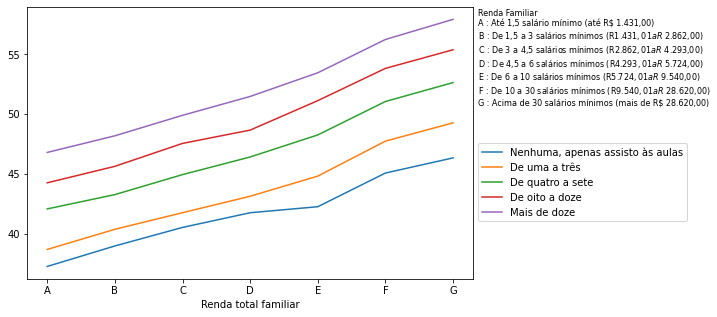

In [7]:
# TABELA - Potencial útil
tmp = pfEnade.groupby(['QE_I08', 'QE_I23'])['NT_GER'].agg(['mean']).unstack() #.where(pfEnade.QE_I08 != ' ')
    
#tmp.index = pd.Series(tmp.index).replace(doRendaDIC())
#tmp.index.name = 'Qual a renda total de sua família, incluindo seus rendimentos?'
tmp.index.name = 'Renda total familiar'

tmp.columns = tmp.columns.droplevel(0)

tmp.columns = pd.Series(tmp.columns).replace(doHEstudoDIC())
#tmp.columns.name = 'Quantas horas por semana, aproximadamente, você dedicou aos estudos, excetuando as horas de aula?'
tmp.columns.name = 'Horas por semana extra classe'

    
ax = tmp.plot(figsize=(8, 5)) 
#ax.set_title('Nota X Renda X Horas', fontsize=15)

textoRenda = "Renda Familiar\n"
for key, value in doRendaDIC().items():
    textoRenda = textoRenda + "{k} : {v}\n".format(k=key, v=value)
ax.text(1.01, 0.6, textoRenda, transform=ax.transAxes, fontsize=8)

#textoEstudo = ""
#for key, value in doRendaDIC().items():
#    textoEstudo = textoEstudo + "{k} : {v}\n".format(k=key, v=value)
#ax.legend(textoEstudo)
ax.legend(bbox_to_anchor=(1.01, 0.5), loc='upper left', borderaxespad=0.)

<AxesSubplot:xlabel='Horas por semana extra classe', ylabel='Renda total familiar'>

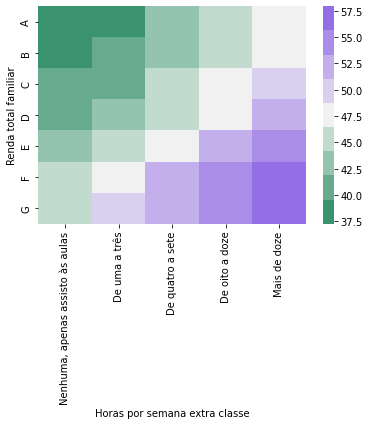

In [8]:
#MAPA CALOR - Potencial útil
sns.heatmap(data=tmp, cmap=sns.diverging_palette(150, 275, s=80, l=55, n=9), )

In [9]:
# TABELA - Possívelmente útil
# Gênero X Nota
tmp = pfEnade.groupby('TP_SEXO')['NT_GER'].agg(['mean', 'std', 'count']).sort_index()
tmp.index = pd.Series(tmp.index).replace(doSexoDIC())
tmp.index.name = 'Sexo'
tmp 

,mean,std,count
Sexo,,,
Feminino,45.288984,14.153478,186146
Masculino,44.074999,14.732116,145603


In [10]:
# TABELA - Possívelmente útil
# Gênero X Nota
tmp.div(tmp.iloc[1])

,mean,std,count
Sexo,,,
Feminino,1.027544,0.960723,1.278449
Masculino,1.000000,1.000000,1.000000


In [11]:
# TABELA - Utilidade não definida
# Sexo X Renda
SxR = pfEnade.groupby(['TP_SEXO', 'QE_I08'])['NT_GER'].agg(['count']).unstack()
    
SxR.index = pd.Series(SxR.index).replace(doSexoDIC())
SxR.index.name = 'Sexo'

SxR.columns = SxR.columns.droplevel(0)
SxR.columns = pd.Series(SxR.columns).replace(doRendaDIC())
SxR.columns.name = 'Qual a renda total de sua família, incluindo seus rendimentos?'
    
SxR 

"Qual a renda total de sua família, incluindo seus rendimentos?","Até 1,5 salário mínimo (até R$ 1.431,00)","De 1,5 a 3 salários mínimos (R$ 1.431,01 a R$ 2.862,00)","De 3 a 4,5 salários mínimos (R$ 2.862,01 a R$ 4.293,00)","De 4,5 a 6 salários mínimos (R$ 4.293,01 a R$ 5.724,00)","De 6 a 10 salários mínimos (R$ 5.724,01 a R$ 9.540,00)","De 10 a 30 salários mínimos (R$ 9.540,01 a R$ 28.620,00)","Acima de 30 salários mínimos (mais de R$ 28.620,00)"
Sexo,,,,,,,
Feminino,38402,55850,36561,19573,20501,12679,2580
Masculino,22538,37336,30262,18008,19662,14663,3134


In [12]:
# BUG
fig, ax = plt.subplots(figsize=(16,8))
plt.suptitle('Título Plot')
SxR.filter(items=['TP_SEXO', 'QE_I08', 'NT_GER'])\
    .groupby(['TP_SEXO', 'QE_I08'])\
    .mean().sort_values(by='NT_GER', ascending=False)\
    .unstack().plot(ax=ax)

DataError: No numeric types to aggregate

In [13]:
SxR.div(SxR.iloc[1])

"Qual a renda total de sua família, incluindo seus rendimentos?","Até 1,5 salário mínimo (até R$ 1.431,00)","De 1,5 a 3 salários mínimos (R$ 1.431,01 a R$ 2.862,00)","De 3 a 4,5 salários mínimos (R$ 2.862,01 a R$ 4.293,00)","De 4,5 a 6 salários mínimos (R$ 4.293,01 a R$ 5.724,00)","De 6 a 10 salários mínimos (R$ 5.724,01 a R$ 9.540,00)","De 10 a 30 salários mínimos (R$ 9.540,01 a R$ 28.620,00)","Acima de 30 salários mínimos (mais de R$ 28.620,00)"
Sexo,,,,,,,
Feminino,1.703878,1.495875,1.208149,1.086906,1.042671,0.864693,0.823229
Masculino,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [14]:
# TABELA - Não útil
# Migrado X Renda X Nota
xq = pfEnade.where(pfEnade.Migrado == 1)
#xq = xq.where(xq.NT_GER != ' ')
#xq = xq.where(xq.NT_GER > 0)
#xq = xq.where(xq.QE_I08 != ' ')

MxR = xq.groupby(['NT_GER', 'QE_I08'])['Migrado'].agg(['count']).unstack()
    
MxR.index = pd.Series(MxR.index).replace(doMigradoDIC())
MxR.index.name = 'Migrado'

MxR.columns = MxR.columns.droplevel(0)
MxR.columns = pd.Series(MxR.columns).replace(doRendaDIC())
MxR.columns.name = 'Qual a renda total de sua família, incluindo seus rendimentos?'
    
MxR 

"Qual a renda total de sua família, incluindo seus rendimentos?","Até 1,5 salário mínimo (até R$ 1.431,00)","De 1,5 a 3 salários mínimos (R$ 1.431,01 a R$ 2.862,00)","De 3 a 4,5 salários mínimos (R$ 2.862,01 a R$ 4.293,00)","De 4,5 a 6 salários mínimos (R$ 4.293,01 a R$ 5.724,00)","De 6 a 10 salários mínimos (R$ 5.724,01 a R$ 9.540,00)","De 10 a 30 salários mínimos (R$ 9.540,01 a R$ 28.620,00)","Acima de 30 salários mínimos (mais de R$ 28.620,00)"
Migrado,,,,,,,
1.5,1,0,0,0,0,0,0
2.2,2,0,0,0,0,0,0
2.3,0,0,1,0,0,0,0
2.6,0,1,0,0,0,0,0
2.7,1,0,0,0,1,0,0
...,...,...,...,...,...,...,...
85.1,0,0,1,0,0,0,0
85.4,0,1,0,0,0,0,0
85.7,0,0,1,0,1,0,0


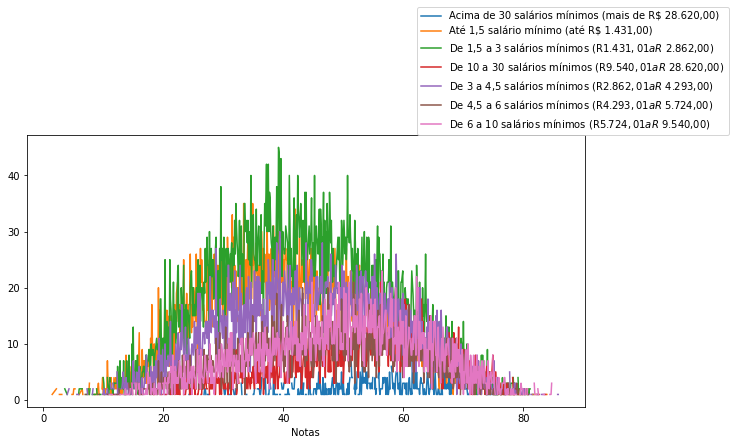

In [15]:
# DISTRIBUIÇÂO - UTIL - Utilizado
#tmp = pfEnade.groupby(['QE_I08', 'QE_I23'])['NT_GER'].agg(['mean']).unstack() #.where(pfEnade.QE_I08 != ' ')
# MxR = pfEnade.groupby(['NT_GER', 'QE_I08'])['Migrado'].agg(['count']).unstack().where('NT_GER > 0')
#MxR = pfEnade.groupby(['NT_GER', 'QE_I08'])['Migrado'].agg(['count']).unstack().where(pfEnade.NT_GER != ' ')
xq = pfEnade.where(pfEnade.Migrado == 1)
MxR = xq.groupby(['NT_GER',  'RendaDIC'])['Migrado']\
    .agg(['count'])\
    .unstack()
    
MxR.index.name = 'Notas'

MxR.columns = MxR.columns.droplevel(0)
MxR.columns.name = 'Renda'
    
ax = MxR.plot(figsize=(10,5)) 
ax.legend(bbox_to_anchor=(0.7, 1), loc=0, borderaxespad=0.)
#ax.set_title('Nota X Renda X Migração', fontsize=20)

# textoRenda = ""
# for key, value in doRendaDIC().items():
#    textoRenda = textoRenda + "{k} : {v}\n".format(k=key, v=value)
#ax.text(0.05, 0.6, textoRenda, transform=ax.transAxes, fontsize=8)

#textoEstudo = ""
#for key, value in doRendaDIC().items():
#    textoEstudo = textoEstudo + "{k} : {v}\n".format(k=key, v=value)
#ax.legend(textoEstudo)